In [70]:
#%pip install matplotlib wordcloud

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, BatchNormalization, Input, Embedding, Dot, Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from wordcloud import WordCloud
%matplotlib inline

### READING ANIMELIST.CSV

In [2]:
import os

In [3]:
INPUT_DIR = os.path.join("..","artifacts","raw")

In [4]:
rating_df = pd.read_csv(INPUT_DIR+"/animelist.csv", low_memory=True, usecols=["user_id","anime_id","rating"])

In [5]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [6]:
len(rating_df)

5000000

### DATA PROCESSING

In [7]:
n_ratings = rating_df["user_id"].value_counts()

In [8]:
n_ratings

user_id
11100    14429
10255     8403
4773      5735
6852      5406
16057     5080
         ...  
9442         1
449          1
443          1
12314        1
16074        1
Name: count, Length: 15186, dtype: int64

In [9]:
rating_df =rating_df[rating_df["user_id"].isin(n_ratings[n_ratings>=400].index)].copy()

In [10]:
len(rating_df)

3246641

In [11]:
min_rating = min(rating_df["rating"])
min_rating

0

In [12]:
max_rating = max(rating_df["rating"])
max_rating

10

In [13]:
avg_rating = np.mean(rating_df["rating"])
avg_rating

np.float64(4.122732695114736)

In [14]:
rating_df["rating"] = rating_df["rating"].apply(lambda x: (x-min_rating)/(max_rating-min_rating)).values.astype(np.float64)

In [15]:
avg_rating = np.mean(rating_df["rating"])
avg_rating

np.float64(0.4122732695114729)

In [16]:
min_rating = min(rating_df["rating"])
min_rating

0.0

In [17]:
max_rating = max(rating_df["rating"])
max_rating

1.0

In [18]:
rating_df.duplicated().sum()

np.int64(0)

In [19]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [20]:
user_ids = rating_df["user_id"].unique().tolist()
user2user_encoded = {x: i for i , x in enumerate(user_ids)}
user2user_decoded = {i: x for i , x in enumerate(user_ids)}
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)


In [21]:
n_users = len(user2user_encoded)
n_users

4203

In [22]:
anime_ids = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x: i for i , x in enumerate(anime_ids)}
anime2anime_decoded = {i: x for i , x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)


In [23]:
n_anime = len(anime2anime_encoded)
n_anime

17149

In [24]:
rating_df = rating_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [25]:
rating_df.head()

,user_id,anime_id,rating,user,anime
0,13338,30,0.7,3405,688
1,15967,15583,0.6,4060,1518
2,4967,39586,0.0,1213,4963
3,4055,8039,0.0,997,4097
4,6170,30205,0.0,1552,1690


In [26]:
X = rating_df[["user","anime"]].values
y = rating_df["rating"]

In [27]:
test_size = 1000
train_indices = rating_df.shape[0]-test_size

In [28]:
X_train, X_test, y_train, y_test = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

In [29]:
len(X_train)

3245641

In [30]:
len(X_test)

1000

In [31]:
type(X_train)

numpy.ndarray

In [32]:
X_train_array = [X_train[:,0], X_train[:,1]]
X_test_array = [X_test[:,0], X_test[:,1]]

In [33]:
type(X_train_array)

list

In [34]:
type(X_test_array)

list

### MODEL ARCHITECTURE

In [35]:
def RecommenderNet():
    embedding_size = 128
    
    user =Input(name="user", shape=[1])
    user_embedding= Embedding(name="user_embedding", input_dim=n_users, output_dim=embedding_size)(user)
    
    anime = Input(name="anime", shape=[1])
    anime_embedding= Embedding(name="anime_embedding", input_dim=n_anime, output_dim=embedding_size)(anime)
    
    x= Dot(name="dot_product", normalize=True, axes=2)([user_embedding, anime_embedding])
    x = Flatten()(x)
    
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x=Activation("sigmoid")(x)
    
    model = Model(inputs=[user, anime], outputs=x)
    model.compile(loss="binary_crossentropy", metrics=["mae", "mse"], optimizer="Adam")
    return model

In [36]:
model = RecommenderNet()

In [37]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

In [38]:
start_lr = 0.00001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000

ramup_epochs =5
sustain_epochs = 0
exp_decay = 0.8

def lrfn(epoch):
    if epoch<ramup_epochs:
        return (max_lr-start_lr)/ramup_epochs*epoch+start_lr 
    elif epoch<ramup_epochs+sustain_epochs:
        return max_lr
    else:
        return (max_lr-min_lr)*exp_decay **(epoch-ramup_epochs-sustain_epochs)+min_lr

In [39]:
lr_callback = LearningRateScheduler(lambda epoch:lrfn(epoch), verbose=0)
checkpoint_filepath = './weights.weights.h5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor="val_loss", mode="min", save_best_only=True)

early_stopping = EarlyStopping(patience=3, monitor="val_loss", mode="min", restore_best_weights=True)


In [40]:
my_callbacks = [model_checkpoint, lr_callback, early_stopping]

In [41]:
history = model.fit(
    x = X_train_array,
    y = y_train,
    batch_size=batch_size,
    epochs = 20,
    verbose=1,
    validation_data = (X_test_array, y_test),
    callbacks = my_callbacks
)

Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 33s 93ms/step - loss: 0.7506 - mae: 0.3729 - mse: 0.1803 - val_loss: 0.6973 - val_mae: 0.3653 - val_mse: 0.1590 - learning_rate: 1.0000e-05
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 27s 84ms/step - loss: 0.7471 - mae: 0.3717 - mse: 0.1789 - val_loss: 0.7280 - val_mae: 0.3727 - val_mse: 0.1733 - learning_rate: 1.8000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 29s 87ms/step - loss: 0.7423 - mae: 0.3699 - mse: 0.1768 - val_loss: 0.7467 - val_mae: 0.3773 - val_mse: 0.1811 - learning_rate: 2.6000e-05
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 31s 94ms/step - loss: 0.7352 - mae: 0.3671 - mse: 0.1737 - val_loss: 0.7439 - val_mae: 0.3766 - val_mse: 0.1799 - learning_rate: 3.4000e-05


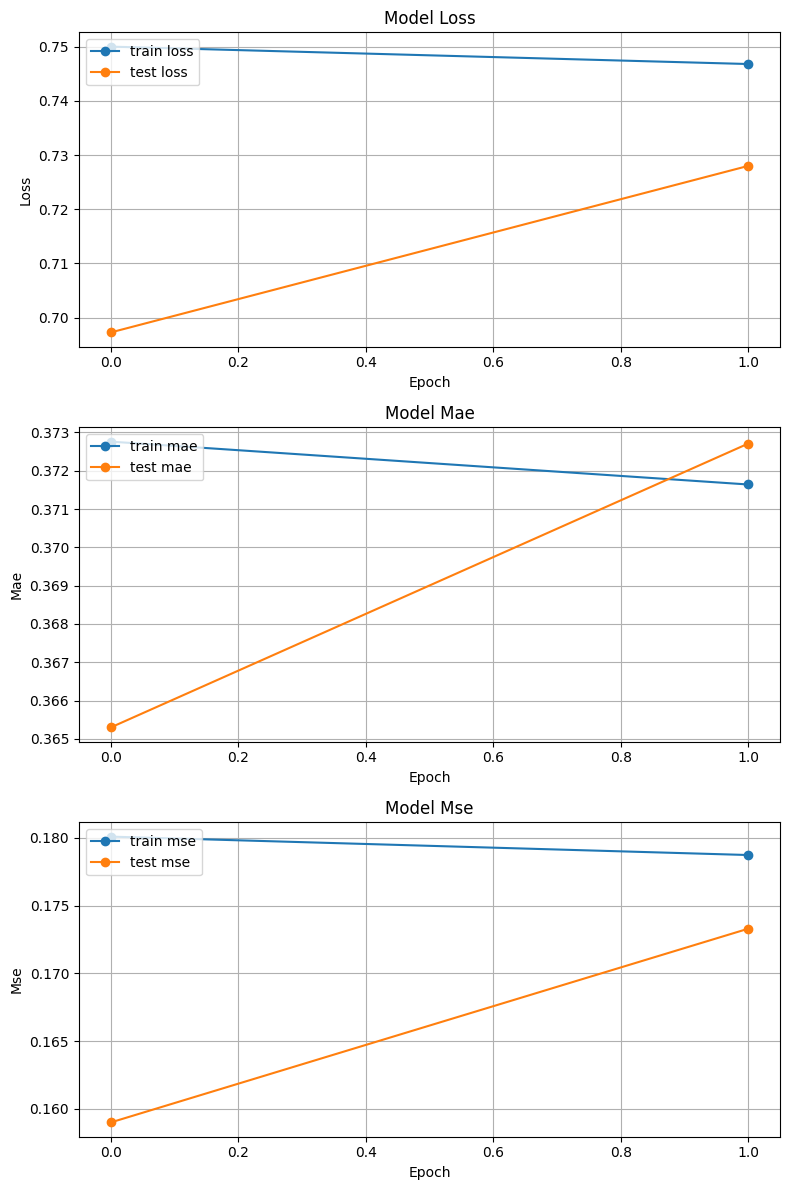

In [42]:
metrics = ["loss", "mae","mse"]

fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics)*4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2], marker="o", label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2], marker="o", label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()
    

In [43]:
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights, axis=1).reshape((-1,1))
    return weights

In [44]:
anime_weights = extract_weights("anime_embedding", model)

In [45]:
user_weights = extract_weights("user_embedding", model)

###READING ANIME.CSV

In [46]:
df = pd.read_csv(INPUT_DIR+"/anime.csv", low_memory=True)

In [47]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [48]:
df = df.replace("Unknown",np.nan)

In [49]:
def getAnimeName(anime_id):
    try:
        name = df[df.anime_id==anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id==anime_id].Name.values[0]
    except:
        print("Error")
    return name

In [50]:
df["anime_id"] = df["MAL_ID"]
df["eng_version"] = df['English name']
df["eng_version"] = df.anime_id.apply(lambda x:getAnimeName(x))

In [51]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1,Cowboy Bebop
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",NaN,...,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,5,Cowboy Bebop:The Movie
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0,6,Trigun
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0,7,Witch Hunter Robin
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0,8,Beet the Vandel Buster


In [52]:
getAnimeName(6702)

'Fairy Tail'

In [53]:
df.sort_values(by=["Score"], 
               inplace=True,
               ascending=False,
               kind="quicksort",
               na_position="last"
               )

In [54]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",Fullmetal Alchemist:Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,...,199160.0,70045.0,20210.0,9308.0,3222.0,1536.0,2162.0,16806.0,5114,Fullmetal Alchemist:Brotherhood
15926,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",Attack on Titan Final Season,進撃の巨人 The Final Season,TV,16,"Dec 7, 2020 to ?",Winter 2021,...,26016.0,8793.0,2674.0,1336.0,588.0,382.0,514.0,11061.0,40028,Attack on Titan Final Season
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",Steins;Gate,STEINS;GATE,TV,24,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,...,140914.0,57740.0,21375.0,11126.0,5061.0,2292.0,1678.0,5255.0,9253,Steins;Gate
14963,38524,Shingeki no Kyojin Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,TV,10,"Apr 29, 2019 to Jul 1, 2019",Spring 2019,...,110481.0,33662.0,8365.0,2974.0,1108.0,550.0,385.0,4169.0,38524,Attack on Titan Season 3 Part 2
9913,28977,Gintama°,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama Season 4,銀魂°,TV,51,"Apr 8, 2015 to Mar 30, 2016",Spring 2015,...,21360.0,10215.0,3898.0,2311.0,952.0,648.0,1100.0,4508.0,28977,Gintama Season 4


In [55]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [56]:
df = df[['anime_id','eng_version', 'Score', 'Genres','Episodes', 'Type','Premiered','Members']]

In [57]:
df.head()

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",51,TV,Spring 2015,404121


In [58]:
def getAnimeFrame(anime, df):
    if isinstance(anime, int):
        return df[df.anime_id == anime]
    if isinstance(anime, str):
        return df[df.eng_version==anime]

In [59]:
getAnimeFrame(40028, df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260


In [60]:
getAnimeFrame('Steins;Gate',df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162


### ANIME_WITH_SYNOPSIS.CSV

In [61]:
cols = ['MAL_ID', 'Name','Genres','sypnopsis']

In [62]:
synopsis_df = pd.read_csv(INPUT_DIR+"/anime_with_synopsis.csv", usecols=cols)

In [63]:
synopsis_df.head()

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...


In [64]:
def getSynopsis(anime, df):
    if isinstance(anime, int):
        return synopsis_df[synopsis_df.MAL_ID==anime].sypnopsis.values[0]
    if isinstance(anime, str):
        return synopsis_df[synopsis_df.Name ==anime].sypnopsis.values[0]

In [65]:
getSynopsis(40028, df)

"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."

In [66]:
getSynopsis('Steins;Gate',df)

'The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective "future gadgets" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed "Daru." The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the "Phone Microwave," which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn\'t provide anything concrete in Okabe\'s search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory 

### CONTENT/ITEM BASED RECOMMENDATION

In [75]:
pd.set_option("max_colwidth", None)

In [95]:
def find_similar_animes(name, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df, n=10, return_dist=False, neg=False):
    # Get the anime_id for the given name
    index = getAnimeFrame(name, df).anime_id.values[0]
    encoded_index = anime2anime_encoded.get(index)

    if encoded_index is None:
        raise ValueError(f"Encoded index not found for anime ID: {index}")

    weights = anime_weights

    # Compute the similarity distances
    dists = np.dot(weights, weights[encoded_index])  # Ensure weights[encoded_index] is a 1D array
    sorted_dists = np.argsort(dists)

    n = n + 1

    # Select closest or farthest based on 'neg' flag
    if neg:
        closest = sorted_dists[:n]
    else:
        closest = sorted_dists[-n:]

    # Return distances and closest indices if requested
    if return_dist:
        return dists, closest

    # Build the similarity array
    SimilarityArr = []
    for close in closest:
        decoded_id = anime2anime_decoded.get(close)
       

       
        anime_frame = getAnimeFrame(decoded_id, df)

        anime_name = anime_frame.eng_version.values[0]
        genre = anime_frame.Genres.values[0]
        similarity = dists[close]
   

        SimilarityArr.append({
            "anime_id": decoded_id,
            "name": anime_name,
            "similarity": similarity,
            "genre": genre,
        })
       

    # Create a DataFrame with results and sort by similarity
    Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
    return Frame[Frame.anime_id != index].drop(['anime_id'], axis=1)


In [96]:
find_similar_animes(
    "Steins;Gate",
    anime_weights,
    anime2anime_encoded,
    anime2anime_decoded,
    df,
    synopsis_df,
)

,name,similarity,genre
9,Chibi Maruko-chan: Jishin wo Kangaeru,0.321682,"Drama, Kids"
8,UNDER THE DOG Anthea-chan,0.307552,"Action, Comedy, Parody"
7,Shenmue: The Movie,0.303449,"Action, Game, Adventure, Martial Arts"
6,Anime Tenchou Movie,0.303025,"Action, Parody"
5,Byeolnala Samchongsa,0.298692,"Adventure, Sci-Fi"
4,Spooky Kitaro,0.297699,"Adventure, Comedy, Fantasy, Horror, Supernatural"
3,Peng You Town,0.293678,"Kids, Slice of Life"
2,Onagawa Chuu Baske Bu: 5-nin no Natsu,0.292852,Sports
1,Shingeki no Bahamut: Genesis - Short Story,0.288753,"Action, Adventure, Demons, Supernatural, Magic, Fantasy"
0,Car Radio,0.287202,Music


### USER BASED RECOMMENDATION

In [79]:
def find_similar_users(item_input , user_weights , user2user_encoded , user2user_decoded, n=10 , return_dist=False,neg=False):
    try:
        index=item_input
        encoded_index = user2user_encoded.get(index)

        weights = user_weights

        dists = np.dot(weights,weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n=n+1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
            

        if return_dist:
            return dists,closest
        
        SimilarityArr = []

        for close in closest:
            similarity = dists[close]

            if isinstance(item_input,int):
                decoded_id = user2user_decoded.get(close)
                SimilarityArr.append({
                    "similar_users" : decoded_id,
                    "similarity" : similarity
                })
        similar_users = pd.DataFrame(SimilarityArr).sort_values(by="similarity",ascending=False)
        similar_users = similar_users[similar_users.similar_users != item_input]
        return similar_users
    except Exception as e:
        print("Error Occured",e)


In [80]:
find_similar_users(int(11880),user_weights,user2user_encoded,user2user_decoded)

,similar_users,similarity
9,4648,0.287162
8,12715,0.278159
7,8859,0.269981
6,10684,0.269741
5,11235,0.268732
4,8022,0.268629
3,12403,0.257893
2,2441,0.254168
1,12755,0.254009
0,3858,0.253775


In [81]:
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700,height=400,background_color='white',colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10,8))
    plt.imshow(genres_cloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [82]:
from collections import defaultdict

In [83]:
df.head(1)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",64,TV,Spring 2009,2248456


In [84]:
def getFavGenre(frame , plot=False):
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)

    genres_list = []
    for genres in frame["Genres"]:
        if isinstance(genres,str):
            for genre in genres.split(','):
                genres_list.append(genre)
                all_genres[genre.strip()] += 1

    if plot:
        showWordCloud(all_genres)
    
    return genres_list



In [85]:
rating_df.head(2)

,user_id,anime_id,rating,user,anime
0,13338,30,0.7,3405,688
1,15967,15583,0.6,4060,1518


In [86]:
def get_user_preferences(user_id , rating_df , df ,plot=False):

    animes_watched_by_user = rating_df[rating_df.user_id == user_id]

    user_rating_percentile = np.percentile(animes_watched_by_user.rating , 75)

    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]

    top_animes_user = (
        animes_watched_by_user.sort_values(by="rating" , ascending=False).anime_id.values
    )

    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["eng_version","Genres"]]

    if plot:
        getFavGenre(anime_df_rows,plot)


    return anime_df_rows




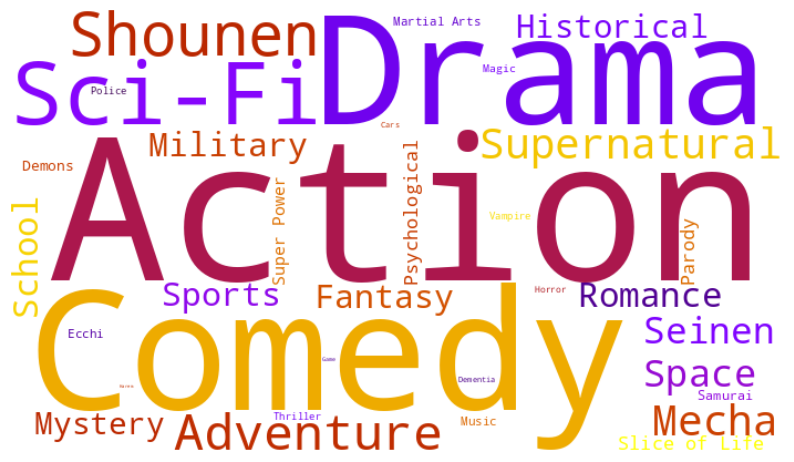

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [88]:
get_user_preferences(11880 , rating_df, df , plot=True)

In [89]:
def get_user_recommendations(similar_users , user_pref ,df , synopsis_df, rating_df, n=10):

    recommended_animes = []
    anime_list = []

    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id) , rating_df, df)

        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]

        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)

    if anime_list:
            anime_list = pd.DataFrame(anime_list)

            sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

            for i,anime_name in enumerate(sorted_list.index):
                n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]

                if isinstance(anime_name,str):
                    frame = getAnimeFrame(anime_name,df)
                    anime_id = frame.anime_id.values[0]
                    genre = frame.Genres.values[0]
                    synopsis = getSynopsis(int(anime_id),synopsis_df)

                    recommended_animes.append({
                        "n" : n_user_pref,
                        "anime_name" : anime_name,
                        "Genres" : genre,
                        "Synopsis": synopsis
                    })
    return pd.DataFrame(recommended_animes).head(n)


In [90]:
similar_users =find_similar_users(int(11880),user_weights,user2user_encoded,user2user_decoded)

In [91]:
user_pref = get_user_preferences(11880 , rating_df, df , plot=False)

In [92]:
get_user_recommendations(similar_users,user_pref,df, synopsis_df,rating_df,n=1)

,n,anime_name,Genres,Synopsis
0,9,Your Name.,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to live the life of a boy in the bustling city of Tokyo—a dream that stands in stark contrast to her present life in the countryside. Meanwhile in the city, Taki Tachibana lives a busy life as a high school student while juggling his part-time job and hopes for a future in architecture. One day, Mitsuha awakens in a room that is not her own and suddenly finds herself living the dream life in Tokyo—but in Taki's body! Elsewhere, Taki finds himself living Mitsuha's life in the humble countryside. In pursuit of an answer to this strange phenomenon, they begin to search for one another. Kimi no Na wa. revolves around Mitsuha and Taki's actions, which begin to have a dramatic impact on each other's lives, weaving them into a fabric held together by fate and circumstance."


### HYBRID RECOMMENDER SYSTEM

In [93]:
def hybrid_recommendation(user_id , user_weight=0.5, content_weight =0.5):

    ## User Recommndation

    similar_users =find_similar_users(user_id,user_weights,user2user_encoded,user2user_decoded)
    user_pref = get_user_preferences(user_id , rating_df, df)
    user_recommended_animes =get_user_recommendations(similar_users,user_pref,df, synopsis_df,rating_df)
    

    user_recommended_anime_list = user_recommended_animes["anime_name"].tolist()
    print(user_recommended_anime_list)

    #### Content recommendation
    content_recommended_animes = []

    for anime in user_recommended_anime_list:
        similar_animes = find_similar_animes(anime, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df)

        if similar_animes is not None and not similar_animes.empty:
            content_recommended_animes.extend(similar_animes["name"].tolist())
        else:
            print(f"No similar anime found {anime}")
    
    combined_scores = {}

    for anime in user_recommended_anime_list:
        combined_scores[anime] = combined_scores.get(anime,0) + user_weight

    for anime in content_recommended_animes:
        combined_scores[anime] = combined_scores.get(anime,0) + content_weight  

    sorted_animes = sorted(combined_scores.items() , key=lambda x:x[1] , reverse=True)

    return [anime for anime , score in sorted_animes[:10]] 



In [97]:
hybrid_recommendation(11880)

['Your Name.', 'A Silent Voice', 'Re:ZERO -Starting Life in Another World-', 'Nisekoi:False Love', 'Code Geass:Lelouch of the Rebellion', "KonoSuba:God's Blessing on This Wonderful World!", 'Little Witch Academia', 'Toradora!', 'Charlotte', 'Steins;Gate']


['Spooky Kitaro',
 'Your Name.',
 'A Silent Voice',
 'Re:ZERO -Starting Life in Another World-',
 'Nisekoi:False Love',
 'Code Geass:Lelouch of the Rebellion',
 "KonoSuba:God's Blessing on This Wonderful World!",
 'Little Witch Academia',
 'Toradora!',
 'Charlotte']